<div style='background-image: url("title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Finite-difference method - Acoustic waves 1D</div>
        </div>
    </div>
</div>


This notebook covers the following aspects:

* implementation of the 1D acoustic wave equation 
* benchmarking with analytical solution


#### Analytical Solution

In the code below we present the analytical solution for the acoustic wave equation

$$
\partial_t^2 p(x,t) \ - \ c^2 \Delta p(x,t) \ = s(x,t)
$$

assuming constant velocity c and infinite space. Note that in 1D and 2D this equation is mathematically equivalent to the problem of SH wave propagation (i.e., shear waves polarised perpendicular to the plane through source and receiver). In 3D it is (only) descriptive of pressure (sound) waves.

Analytical solution for inhomogeneous partial differential equations (i.e., with non-zero source terms) are usually developed using the concept of Green's functions $G(x, t; x_0, t_0)$. Green's functions are the solutions to the specific partial differential equations for $\delta$-function as source terms evaluated at $(x, t)$ and activated at $(x_0, t_0)$. Thus, we seek solutions to 

$$
\partial_t^2 G(x,t;x_0, t_0) \ - \ c^2 \Delta G(x,t;x_0, t_0) \ = \delta (x-x_0) \delta (t-t_0)
$$

where $\Delta$ is the Laplace operator. We recall the definition of the  $\delta-$function as a generalised function with

$$
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.
$$

and

$$
\int_{-\infty}^{\infty}\delta(x)dx\ = \ 1 \ , \   \int_{-\infty}^{\infty}f(x)\delta(x)dx\ = \ f(0) \ 
$$

When comparing numerical with analytical solutions the functions that - in the limit - lead to the $\delta-$function will become very important. An example is the boxcar function

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

fulfilling these properties as $dx\rightarrow0$. These functions are used to properly scale the source terms to obtain correct absolute amplitudes.

To describe analytical solutions for the acoustic wave equation we also make use of the unit step function, also known as the Heaviside function, defined as 

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

The Heaviside function is the integral of the $\delta-$function (and vice-versa the $\delta$-function is defined as the derivative of the Heaviside function). In 1D case, the Greens function is proportional to a Heaviside function. 

$$
G=\frac{1}{2c}H(t-\frac{|r|}{c})
$$

$$
r=x
$$

As the response to an arbitrary source time function can be obtained by convolution this implies that the propagating waveform is the integral of the source time function. The response is shown for a source time function with a 1st derivative of a Gaussian.

#### Numerical Solution (Finite Differences Method)

The acoustic wave equation in 1D with constant density 

$$
\partial^2_t p(x,t) \ = \ c(x)^2 \partial_x^2 p(x,t) + s(x,t)
$$

with pressure $p$, acoustic velocity $c$, and source term $s$ contains two second derivatives that can be approximated with a difference formula such as

$$
\partial^2_t p(x,t) \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2} 
$$

and equivalently for the space derivative. Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an explicit scheme allowing the $extrapolation$ of the space-dependent field into the future only looking at the nearest neighbourhood.

We replace the time-dependent (upper index time, lower indices space) part by

$$
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{\mathrm{d}t^2} \ = \ c^2 ( \partial_x^2 p) \ + s_{i}^n
$$

solving for $p_{i}^{n+1}$.

The extrapolation scheme is

$$
p_{i}^{n+1} \ = \ c_i^2 \mathrm{d}t^2 \left[ \partial_x^2 p \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n
$$

The  space derivatives are determined by 

$$
\partial_x^2 p \ = \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2}
$$

### Analytical and Numerical Comparisons
The code below is given with a 3-point difference operator. Compare the results from the numerical simulation with the 3-point operator with the analytical solution.

### High-order operators
Extend the code to higher order by adding the option to use a 5-point difference operator. The 5-pt weights are: 
$
[-1/12, 4/3, -5/2, 4/3, -1/12] / dx^2
$. 
Compare simulations of the 3-point and 5-point operators.

---

In [1]:
# Import Libraries 
# ----------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Show Plot in The Notebook
# -------------------------
plt.switch_backend("nbagg") 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Parameter Configuration 
# -----------------------

nx   = 10000        # number of grid points in x-direction
xmax = 10000        # physical domain (m)
dx   = xmax/(nx-1)  # grid point distance in x-direction       
c0   = 334.         # wave speed in medium (m/s)
isrc = nx//2         # source location in grid in x-direction
ir   = isrc+100     # receiver location in grid in x-direction
nt   = 600          # maximum number of time steps
dt   = 0.002       # time step
f0   = 100.         # dominant frequency of the source (Hz)
t0   = 4. / f0      # source time shift

# CFL Stability Criterion
# -----------------------
eps  = c0 * dt / dx # epsilon value

print('Stability criterion =', eps)

Stability criterion = 0.6679332000000001


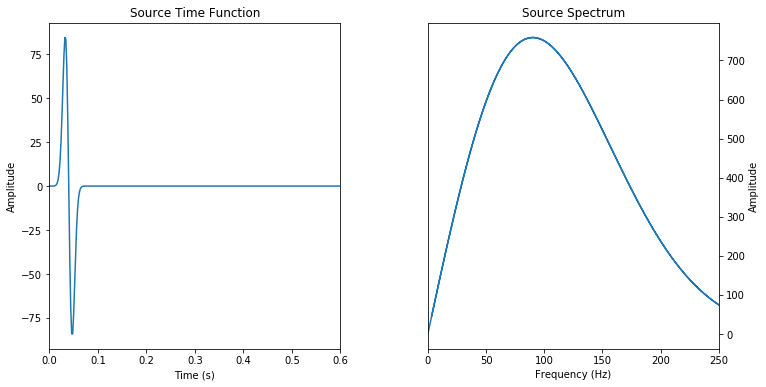

In [3]:
# Plot Source Time Function 
# -------------------------

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)
# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time - t0) ** 2))

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# ---------------------------
# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(12, 6))
gs1  = gridspec.GridSpec(1,2,width_ratios=[1,1], height_ratios=None, hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1]/2)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

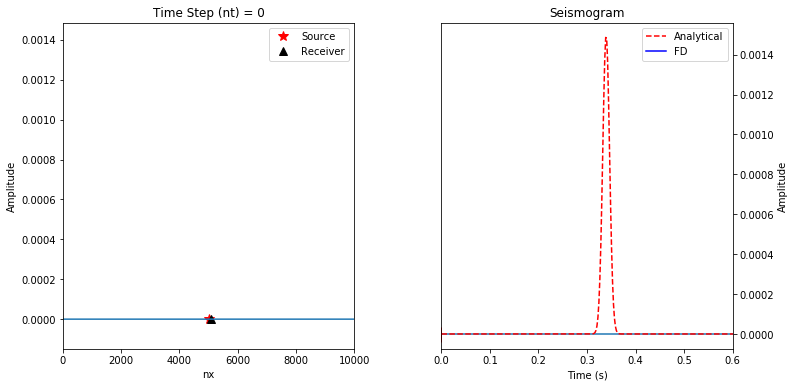

In [4]:
# Plot Snapshot & Seismogram 
# ---------------------------------------------------------------------------

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.zeros(nx)
c    = c + c0       # initialize wave velocity in model

# Initialize coordinate
# ---------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

# Initialize empty seismogram
# ---------------------------
seis = np.zeros(nt) 

# Analytical solution
# -------------------
G    = time * 0.
for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / c0) >= 0:
        G[it] = 1. / (2 * c0)
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

# To avoid testing (with py.test nbval ...) the plotting section 
# NBVAL_IGNORE_OUTPUT
# ---------------------------
# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(12, 6))
gs2   = gridspec.GridSpec(1,2,width_ratios=[1,1],hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, nx)
ax3.set_ylim(-0.1*lim, lim)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('nx')
ax3.set_ylabel('Amplitude')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
leg3,= ax4.plot(0,0,'r--',markersize=1) # plot analytical solution marker
leg4,= ax4.plot(0,0,'b-',markersize=1) # plot numerical solution marker
up41,= ax4.plot(time, seis) # update recorded seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlim(time[0], time[-1]/2)
ax4.set_title('Seismogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

plt.plot(time,Gc,'r--') # plot analytical solution
plt.show()

In [5]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# FD Point Operator (choose 3 or 5 point operator)
# ------------------------------------------------
op   = 3
print(op, '- point operator')

# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    if op==3: # use 3 point operator FD scheme
        for i in range(1, nx - 1):
            d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    if op==5: # use 5 point operator FD scheme
        for i in range(2, nx - 2):
            d2px[i] = (-1./12 * p[i + 2] + 4./3  * p[i + 1] - 5./2 * p[i] \
                       +4./3  * p[i - 1] - 1./12 * p[i - 2]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2
    
            
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[ir]
    
    # Update Data for Wave Propagation Plot
    # -------------------------------------
    idisp = 5 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        up31.set_ydata(p)
        # To avoid testing (with py.test nbval ...) the plotting section 
        # NBVAL_IGNORE_OUTPUT
        # ----------------------------
        # plot around propagating wave
        window=100;xshift=25
        ax3.set_xlim(isrc*dx+c0*it*dt-window*dx-xshift, isrc*dx+c0*it*dt+window*dx-xshift)
        up31.set_ydata(p)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()

3 - point operator


<Figure size 432x288 with 0 Axes>